In [1]:
from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4, ErrorCode, Variable, plotTrajectoriesFile, Field, ScipyParticle
from glob import glob
import numpy as np
import pandas as pd
from datetime import timedelta as delta
from datetime import date
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
cartopy.config['pre_existing_data_dir'] = '/home1/datawork/kbalem/cartopy_shapefiles/'
cartopy.config['data_dir'] = '/home1/datawork/kbalem/cartopy_shapefiles/'
cartopy.config['repo_data_dir'] = '/home1/datawork/kbalem/cartopy_shapefiles/'
import cartopy.crs as ccrs
import cartopy.feature as cfeature
land_feature=cfeature.NaturalEarthFeature(category='physical',name='land',scale='50m',facecolor=[120/255, 108/255, 92/255])

In [2]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 31.35 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36661,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 31.35 GiB
Comm: tcp://127.0.0.1:46681,Total threads: 2
Dashboard: http://127.0.0.1:43939/status,Memory: 7.84 GiB
Nanny: tcp://127.0.0.1:38793,


In [ ]:
#client.close()

distributed.nanny - WARNING - Worker process still alive after 3.999998092651367 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3.999998092651367 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3.999997901916504 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3.999997901916504 seconds, killing


# 1. Data input
First thing to do is to set up our input data fields. We have to tell parcels where to find the data, which data to use (the velocities are mandatory to advect the particles of course, but we can set up other variables to build some virtual dataset or to mimic the ISA behavior with ice variables

In [3]:
# This is where the data is stored. Note that here, we only load one year of data, and in the FieldSet instance, we loop over this year. 
data_path = '/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG12.L75/CREG12.L75-REF08-S/5d/'
# Velocity files
ufiles = sorted(glob(data_path+'2014/*_gridU.nc'))
vfiles = sorted(glob(data_path+'2014/*_gridV.nc'))
# TS files
tfiles = sorted(glob(data_path+'2014/*_gridT.nc'))
# Ice files 
ifiles = sorted(glob(data_path+'2014/*_icemod.nc'))
# And the coordinates files, also mandatory for nemo grid, to apply variables at the right place
mesh_mask = '/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG12.L75/GRID/coordinates_CREG12.L75.nc'

# Then we build the directories that are passed to parcels
filenames = {'U': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': ufiles[0], 'data': ufiles},
             'V': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': ufiles[0], 'data': vfiles},
             'T': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': tfiles[0], 'data': tfiles},
             'S': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': tfiles[0], 'data': tfiles},
             'I': {'lon': mesh_mask, 'lat': mesh_mask, 'data': ifiles}}

variables = {'U': 'vozocrtx', 'V': 'vomecrty', 'T': 'votemper', 'S': 'vosaline', 'I': 'siconc'}

dimensions = {'U': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthu', 'time': 'time_counter'},
              'V': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthu', 'time': 'time_counter'},
              'T': {'lon': 'glamt', 'lat': 'gphit', 'depth': 'deptht', 'time': 'time_counter'},
              'S': {'lon': 'glamt', 'lat': 'gphit', 'depth': 'deptht', 'time': 'time_counter'},
              'I': {'lon': 'glamt', 'lat': 'gphit', 'time': 'time_counter'}}

# Here we instantiate the FieldSet parcels object, looping over the loaded year of data with the time_periodic option
fieldset = FieldSet.from_nemo(filenames, variables, dimensions, time_periodic=delta(days=365), chunksize='auto')
#fieldset = FieldSet.from_nemo(filenames, variables, dimensions, time_periodic=delta(days=365))

In [4]:
# Very important ! this should be automatically detected in parcels, but in some case it is not, so we make sure that longitude periodicity is set (for this product)
fieldset.U.grid.zonal_periodic = True
fieldset.V.grid.zonal_periodic = True
fieldset.T.grid.zonal_periodic = True
fieldset.S.grid.zonal_periodic = True
fieldset.I.grid.zonal_periodic = True
# Shifing max latitude value to 90. so interpolation at the pole behave better
fieldset.U.lat[fieldset.U.lat==fieldset.U.lat.max()] = 90.0
fieldset.V.lat[fieldset.V.lat==fieldset.V.lat.max()] = 90.0
fieldset.T.lat[fieldset.T.lat==fieldset.T.lat.max()] = 90.0
fieldset.S.lat[fieldset.S.lat==fieldset.S.lat.max()] = 90.0
fieldset.I.lat[fieldset.I.lat==fieldset.I.lat.max()] = 90.0
fieldset.U.grid.lonlat_minmax[3] = 90.0
fieldset.V.grid.lonlat_minmax[3] = 90.0
fieldset.T.grid.lonlat_minmax[3] = 90.0
fieldset.S.grid.lonlat_minmax[3] = 90.0
fieldset.I.grid.lonlat_minmax[3] = 90.0

Still some problems at the very north pole, some particles are lost when latitude is very close to 90°.
This is because the grid index search is somehow lost when reaching the 90° latitude value.  

I added some lines in parcels code (for my installation only), in ```parcels/include/index_search.h``` (for JIT mode) :  
If maxiteration is reached, in our case it usually means that the searched is stucked in top cell of the grid.  
So I check if this is the case (ie if **xy_minmax[3]** is in **ygrid_loc**), if so, I break the while
```
if ( it > maxIterSearch){
      // KEVIN MARCH 2022
      if (ygrid_loc[0] = xy_minmax[3]) break;
      if (ygrid_loc[1] = xy_minmax[3]) break;
      if (ygrid_loc[2] = xy_minmax[3]) break;
      if (ygrid_loc[3] = xy_minmax[3]) break;
```
Same change has been done in ```parcels/field.py``` (for Scipy mode) :
```
if it > maxIterSearch:
    #CHANGE BY KEVIN MARCH 2022 : to detech search stuck in the top cell
    if(grid.lonlat_minmax[3] in py):
        break;
```

Let's compute one time step and plot the fields to check what they look like

# 2. The mask
We can notice on the previous plot, that parcels turns any NaN values to 0. Indeed, for particle advection, a NaN or 0 value in velocity is the same.
But in our case we want to mimic argo float behaviour, so we want to be able to detect NaN values vertically, to detect seafloor (if the floadt grounds before reaching its parking depth, the profile starts here, and if the float grounds during parking, it goes up 50 db and keep drifting if possible, otherwise it goes up 50 db again). 
So in addition the scientific fields, we'll add a "mask" field.

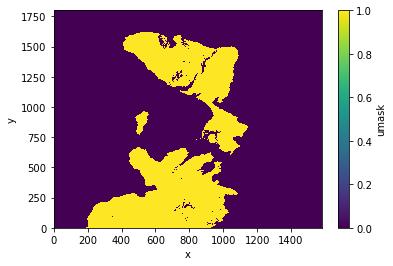

In [5]:
# Strong hypothesis : NaN values from 1st U fields file are applicable to other variables...
msk = xr.open_dataset('/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG12.L75/GRID/CREG12.L75-REF08_mask.nc')
msk = msk.isel(t=0)
msk = msk['umask'].where(((msk['umask']==1) & (msk['vmask']==1)),drop=False).fillna(0)
msk.isel(z=50).plot()

In [6]:
# Fieldset must be just created (no simulation yet) before adding a new field instance
# Here we add the topo mask at U coordinates, this is probably not the best solution.
fieldset.add_field(Field('mask',msk.values,lon=fieldset.U.lon,lat=fieldset.U.lat,depth=fieldset.U.depth,mesh='spherical',interp_method='nearest'))

# 3. Argo kernel = mimic the argo behavior

### ISA behavior for our floats :
```
ISA detection :
Between 2 thresholds (IC3 & IC4, 30 & 10 dB); float computes median temperature. If temperature is inferior to IC5 (-1.60°C), float decides ice detection as positive. From threshold IC6 (default 150 dB), float decreases speed from approx. 9 cm/sec to approx. 3.33 cm/sec (default values), to acquire necessary raw CTD data to compute median temperature. 
Ice detection is confirmed if IC2 (default 3) consecutives ISA detections are raised.
```

In [7]:
class ArgoParticle(JITParticle):    
    #class ArgoParticle(JITParticle):
    """ Internal class used by parcels to add variables to particle kernel    
    """
    # Phase of cycle: init_descend = 0, drift = 1, profile_descend = 2, profile_ascend = 3, transmit = 4    
    cycle_phase = Variable('cycle_phase', dtype=np.int32, initial=0.)
    cycle_age = Variable('cycle_age', dtype=np.float32, initial=0.)
    drift_age = Variable('drift_age', dtype=np.float32, initial=0.)
    # Add a variable to the particle to track if particle is "in water" ie, if the uv value at that depth is finite.
    in_water = Variable('in_water', dtype=np.float32, initial=1.)
    # Add a temp variable for ISA behavior
    isa = Variable('isa',dtype=np.float32, initial=0.)
    # Other scientific variables we want to keep track of
    votemper = Variable('votemper', dtype=np.float32)
    vosaline = Variable('vosaline', dtype=np.float32)
    siconc = Variable('siconc', dtype=np.float32)
    isatemp = Variable('isatemp',dtype=np.float32, initial=0.)    

def ArgoVerticalMovement(particle, fieldset, time):
    """ This is the kernel definition that mimics the argo float behaviour.
        It can only have (particle, fieldset, time) as arguments. So missions parameters are passed as constants through the fieldset.         
        
        BE CAREFULL, i,j,k VARIABLES CAN ONLY BE USED AS INTEGERS
    """   
    driftdepth = fieldset.parking_depth
    maxdepth = fieldset.profile_depth
    mindepth = 1  # not too close to the surface so that particle doesn't go above it
    vertical_speed = fieldset.v_speed  # in m/s
    cycletime = fieldset.cycle_duration * 86400  # in s
    # ISA constants
    ic3_depth = fieldset.ic3
    ic4_depth = fieldset.ic4
    ic5_thres = fieldset.ic5
    ic6_depth = 150.
    isa_speed = 0.033
    
    # Calculation of ice detection, let's try to calculate temperature median between ic3 & ic4  
    # It has to be raw so that numba & parcels accepts it
    hlen = 11
    isa_drange = [10.,12.,14.,16.,18.,20.,22.,24.,26.,28.,30.]
    temp_isa = [0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.]
    i=0
    while (i<hlen):        
        temp_isa[i] = fieldset.T[time,isa_drange[i], particle.lat, particle.lon]
        i = i+1          
    # Raw sorting   
    temp = -10.
    i=0
    while i<hlen :    
        j = i+1
        while j<hlen :
            if(temp_isa[i] > temp_isa[j]):    
                temp = temp_isa[i]
                temp_isa[i] = temp_isa[j]
                temp_isa[j] = temp
            j = j+1    
        i = i+1        
    # End raw sorting    
        
    # Median value 
    particle.isatemp = temp_isa[5]
    #particle.isatemp = fieldset.T[time,(ic3_depth+ic4_depth)/2., particle.lat, particle.lon]
    
    if particle.isatemp < ic5_thres :
        particle.isa = 1.
    else :
        particle.isa = 0.       
    
    # Interpolation of variables other than velocities
    particle.in_water = fieldset.mask[time, particle.depth, particle.lat, particle.lon]
    particle.votemper = fieldset.T[time, particle.depth, particle.lat, particle.lon]
    particle.vosaline = fieldset.S[time, particle.depth, particle.lat, particle.lon]
    particle.siconc = fieldset.I[time, particle.depth, particle.lat, particle.lon]

    # Compute drifting time so that the cycletime is respected:
    # Time to descent to parking (mindepth to driftdepth at vertical_speed)
    transit = (driftdepth - mindepth) / vertical_speed
    # Time to descent to profile depth (driftdepth to maxdepth at vertical_speed)
    transit += (maxdepth - driftdepth) / vertical_speed
    # Time to ascent (maxdepth to mindepth at vertical_speed)
    transit += (maxdepth - mindepth) / vertical_speed
    drifttime = cycletime - transit

    # Grounding management : Since parcels turns NaN to Zero within our domain, we have to manage
    # groundings in another way that the recovery of deleted particles (below)
    if not particle.in_water:
        # if we're in phase 0 or 1 :
        # -> rising 50 db and start drifting (phase 1)
        if particle.cycle_phase <= 1:
            #print(
            #    "Grouding during descent to parking or during parking, rising up 50m and try drifting here.")
            particle.depth = particle.depth - 50
            particle.in_water = fieldset.mask[time, particle.depth, particle.lat,
                                      particle.lon]
            particle.cycle_phase = 1
        # if we're in phase 2:
        # -> start profiling (phase 3)
        elif particle.cycle_phase == 2:
            #print("Grounding during descent to profile, starting profile here")
            particle.cycle_phase = 3
        else:
            pass    

    # CYCLE MANAGEMENT
    if particle.cycle_phase == 0:        
        # Phase 0: Sinking with vertical_speed until depth is driftdepth
        particle.depth += vertical_speed * particle.dt
        particle.in_water = fieldset.mask[time, particle.depth, particle.lat,
                                      particle.lon]
        if particle.depth >= driftdepth:
            particle.cycle_phase = 1            

    elif particle.cycle_phase == 1:
        # Phase 1: Drifting at depth for drifttime seconds        
        particle.drift_age += particle.dt        
        
        if particle.drift_age >= drifttime:
            particle.drift_age = 0  # reset drift_age for next cycle
            particle.cycle_phase = 2

    elif particle.cycle_phase == 2:
        # Phase 2: Sinking further to maxdepth        
        particle.depth += vertical_speed * particle.dt
        particle.in_water = fieldset.mask[time, particle.depth, particle.lat,
                                      particle.lon]
        if particle.depth >= maxdepth:
            particle.cycle_phase = 3

    elif particle.cycle_phase == 3:
        # Phase 3: Rising with vertical_speed until at surface                
        
        particle.depth -= vertical_speed * particle.dt
        particle.in_water = fieldset.mask[time, particle.depth, particle.lat,
                                      particle.lon]
        # ISA Behavior
        if particle.depth < ic6_depth:
            vertical_speed = isa_speed
            
        # If reaching IC4 and ISA==1. GOING DOWN WITHOUT SURFACING
        if particle.depth < ic4_depth :
            if particle.isa == 1. :
                particle.depth = ic4_depth
                particle.cycle_phase = 0
        
        if particle.depth <= mindepth:
            particle.depth = mindepth
            particle.cycle_phase = 4

    elif particle.cycle_phase == 4:
        # Phase 4: Transmitting at surface until cycletime is reached        
        if particle.cycle_age >= cycletime:
            particle.cycle_phase = 0
            particle.cycle_age = 0

    particle.cycle_age += particle.dt  # update cycle_age

# define recovery for OutOfBounds Error
def DeleteParticle(particle, fieldset, time):

    # Get velocity field bounds
    lat_min = fieldset.U.lat.min()
    lat_max = fieldset.U.lat.max()
    lon_min = fieldset.U.lon.min()
    lon_max = fieldset.U.lon.max()
    # Get the center of the cellgrid for depth
    dgrid = fieldset.gridset.grids[0].depth
    depth_min = dgrid[0] + (dgrid[1]-dgrid[0])/2
    depth_max = dgrid[-2]+(dgrid[-1]-dgrid[-2])/2
    
    # in the air, calm down float !
    if (particle.depth < depth_min):
        #print("Field Warning : Particle above surface, depth set to product min_depth.")
        particle.depth = depth_min
        particle.cycle_phase = 4
    # below fieldset
    elif (particle.depth > depth_max):
        # if we're in phase 0 or 1 :
        # -> set particle depth to max non null depth, ascent 50 db and start drifting (phase 1)
        if particle.cycle_phase <= 1:
            #print("Field warning : Particle below the fieldset, your dataset is probably not deep enough for what you're trying to do. It will drift here")
            particle.depth = depth_max - 50
            particle.cycle_phase = 1
        # if we're in phase 2 :
        # -> set particle depth to max non null depth, and start profiling (phase 3)
        elif particle.cycle_phase == 2:
            #print("Field warning : Particle below the fieldset, your dataset is not deep enough for what you're trying to do. It will start profiling here")
            particle.depth = depth_max
            particle.cycle_phase = 3
    else:
        # I don't know why yet but in some cases, during ascent,  I get an outOfBounds error, even with a depth > depth_min...
        if particle.cycle_phase == 3:
            particle.depth = depth_min
            particle.cycle_phase = 4
        else :
            print(particle.cycle_phase, particle.lon, particle.lat, particle.depth)
            #print("Field Warning : Other OutOfBounds --> deleted")
            particle.delete()
            
# We want a continuous longitude
def periodicBC(particle, fieldset, time):
    if particle.lon < -180.:
        particle.lon += 360.
    elif particle.lon > 180.:
        particle.lon -= 360.              

# 4. Let's define a particle set, ie some virtual argo floats

In [11]:
# Add constants to field (easier way to include some user value within the simulation) to set the mission parameters
fieldset.add_constant('parking_depth', 500.)
fieldset.add_constant('profile_depth', 2000.)
fieldset.add_constant('v_speed', 0.09)
fieldset.add_constant('cycle_duration', 8.)
fieldset.add_constant('ic3', 30.)
fieldset.add_constant('ic4', 10.)
fieldset.add_constant('ic5', -1.6)

# define parcels particleset
# define parcels particleset
laa = np.linspace(82.0,89.9,50,endpoint=False)
loa = np.linspace(30.,30.,50,endpoint=False)

pset = ParticleSet(fieldset=fieldset,
                   pclass=ArgoParticle,
                   lon=loa,    # release longitudes 
                   lat=laa,   # release latitudes 
                   depth=np.linspace(2.,2.,len(loa)),     # release depth 
                   time= np.linspace(0.,0.,len(loa))    # release time
                   )

# Kernels that are going to manage advection
kernels = ArgoVerticalMovement + pset.Kernel(AdvectionRK4) + pset.Kernel(periodicBC)

# Let's try this : https://github.com/OceanParcels/parcels/pull/954
pset.populate_indices()

Let's plot the particle set

Text(0.5, 1.0, '50 particles')

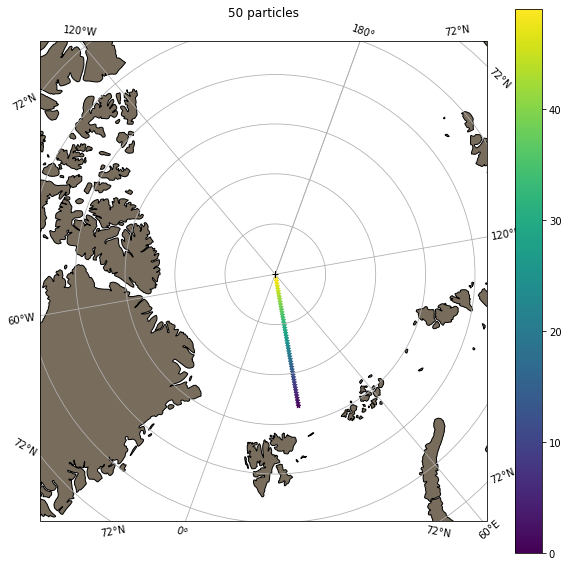

In [27]:
pr1=ccrs.PlateCarree()
pr2=ccrs.Orthographic(20.0,90.)

fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=pr2)
ax.plot(0,90,'k+',transform=pr1)
pl=ax.scatter(pset.lon,pset.lat,s=20,c=range(len(pset)),transform=pr1,marker='*')
ax.set_extent([-180,180,75,90],crs=pr1)
ax.add_feature(land_feature, edgecolor='black')
ax.gridlines(draw_labels=True)
plt.colorbar(pl)
plt.title(str(len(pset))+ ' particles')

# 5. Run simulation
There are 3 parameters to tune here :
- runtime = duration of the simulation
- dt = this is the time step of the simulation, it has to be small so that the argo kernel can behave properly. If it's too large, it cannot detect correctly a specific depth.
- outputdt (from ParticleFile) = this is the time step that is written in the output file. Writing all the time step is very time consuming for the simulation.

In [28]:
outputfilename = 'nctraj/test_median_tweak_1y.nc'
pset.execute(kernels, 
             runtime=delta(days=365.),
             dt=delta(minutes=5),             
             output_file=pset.ParticleFile(name=outputfilename, outputdt=delta(hours=0.5)),
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle, 
                       ErrorCode.ErrorThroughSurface: DeleteParticle}
             )

INFO: Compiled ArrayArgoParticleArgoVerticalMovementAdvectionRK4periodicBC ==> /tmp/parcels-500721/libabc62476d332323a12739a218a449a25_0.so
INFO: Temporary output files are stored in nctraj/out-KUCPRTDW.
INFO: You can use "parcels_convert_npydir_to_netcdf nctraj/out-KUCPRTDW" to convert these to a NetCDF file during the run.
100% (31536000.0 of 31536000.0) |########| Elapsed Time: 1:49:01 Time:  1:49:01


In [29]:
# Load simulation results:
simu = xr.open_dataset(outputfilename,decode_times=False)
simu

<xarray.Dataset>
Dimensions:      (traj: 50, obs: 17521)
Dimensions without coordinates: traj, obs
Data variables: (12/25)
    trajectory   (traj, obs) float64 ...
    time         (traj, obs) float64 ...
    lat          (traj, obs) float64 ...
    lon          (traj, obs) float64 ...
    z            (traj, obs) float64 ...
    cycle_phase  (traj, obs) float32 ...
    ...           ...
    tl5          (traj, obs) float32 ...
    tl6          (traj, obs) float32 ...
    tl7          (traj, obs) float32 ...
    tl8          (traj, obs) float32 ...
    tl9          (traj, obs) float32 ...
    tl10         (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.0
    parcels_mesh:           spherical